In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Step 1: Load the data into a pandas DataFrame
filename = "./data/session.acceleration.27-09-2024.23-13-02.csv"
data = pd.read_csv(filename)  # Replace with your actual CSV file path

In [7]:
df = data.copy()
# Convert the timestamp to relative time in seconds (assuming it's in microseconds)
df['time'] = (df['timestamp'] - df['timestamp'][0]) / 1e9  # Convert to seconds from start
# Step 2: Compute the acceleration magnitude
df['acc_mag'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

In [52]:
# Step 3: Design and apply a high-pass filter
def highpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

def lowpass_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Estimate the sampling frequency (fs) from the data
df['dt'] = df['time'].diff()
mean_dt = df['dt'].mean()
fs = 1 / mean_dt

# Apply high-pass filter with a cutoff frequency of 1 Hz
cutoff = 1  # Cutoff frequency in Hz
df['acc_filtered'] = highpass_filter(df['acc_mag'], cutoff, fs)


# Step 4: Compute the vibration intensity
# Compute the squared filtered acceleration (vibration energy)
df['acc_squared'] = df['acc_filtered'] ** 2

# Choose a cutoff frequency for the low-pass filter (e.g., 0.5 Hz)
lowpass_cutoff = 0.5  # Hz
df['acc_energy_smoothed'] = lowpass_filter(df['acc_squared'], lowpass_cutoff, fs)

# # Compute the RMS acceleration (vibration intensity)
df['vibration_intensity'] = np.sqrt(df['acc_energy_smoothed'])

/Users/michaelshtutman/Library/Caches/pypoetry/virtualenvs/scootertester-process-AtXOTJ2v-py3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [92]:
df['vibration_max'] = df['vibration_intensity'].rolling(window=10000).max()
df['vibration_mean'] = df['vibration_intensity'].rolling(window=10000).median()

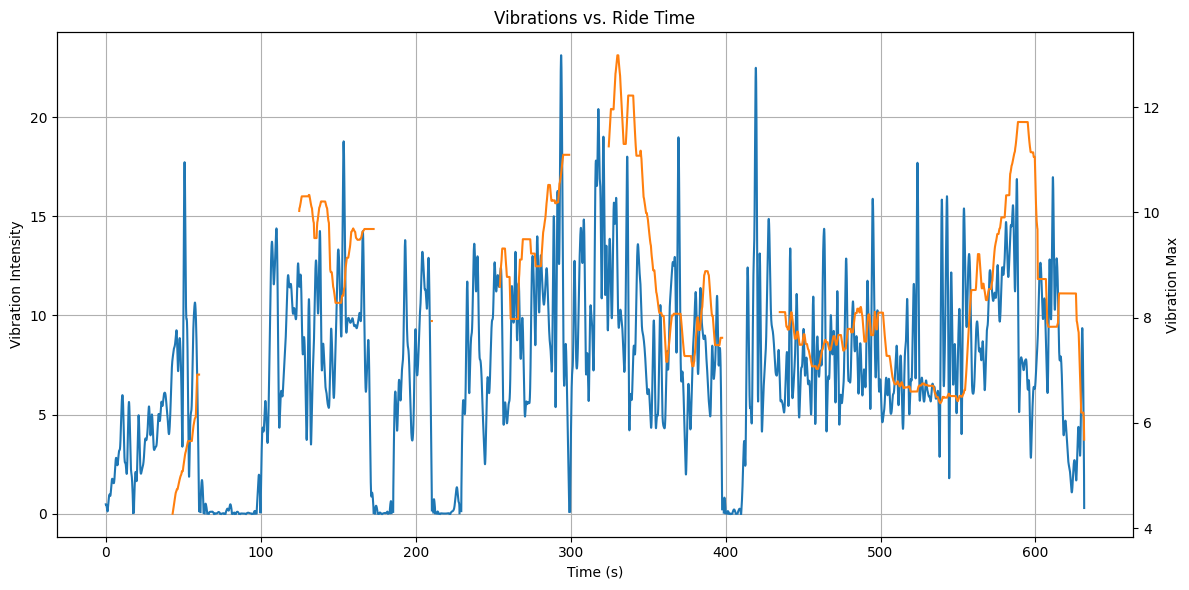

In [93]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df['time'], df['vibration_intensity'])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Vibration Intensity')
ax1.grid(True)

ax2 = ax1.twinx()

ax2.plot(df['time'], df['vibration_mean'], color='tab:orange')
ax2.set_ylabel('Vibration Max')

plt.title('Vibrations vs. Ride Time')
fig.tight_layout()
plt.show()